In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import copy


In [2]:
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_68k_Zheng/Zheng_PBMC.h5ad')
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_68k_Zheng\Zheng_PBMC.h5ad")
adata.shape

(68579, 32738)

In [3]:
adata.obs.head()

,celltype,TSNE.1,TSNE.2
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970


In [4]:
adata.var.head()

,gene_symbols
ENSG00000243485,MIR1302-10
ENSG00000237613,FAM138A
ENSG00000186092,OR4F5
ENSG00000238009,RP11-34P13.7
ENSG00000239945,RP11-34P13.8


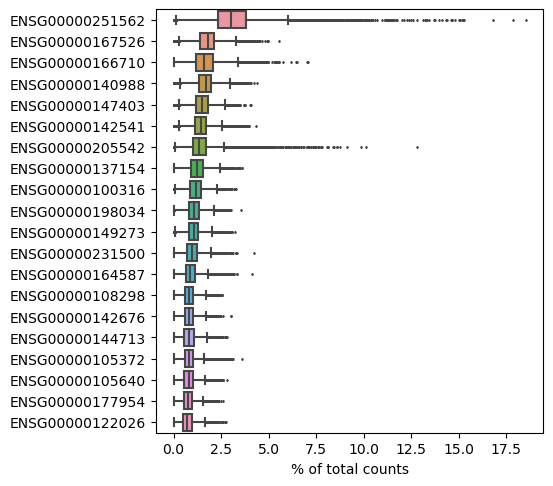

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20)

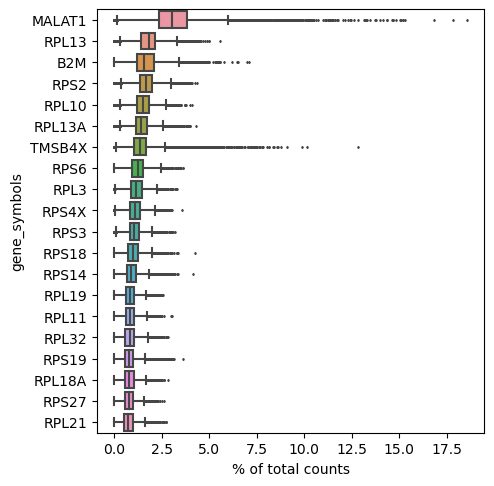

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='gene_symbols')

## Quality control
(did not actually filter out cells)

In [ ]:
# Calculate quality control metrics
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var['gene_symbols'].str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [ ]:
# quality control violin plot
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
# quality control violin plot
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             stripplot=False, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [ ]:
# filtering out the low quality cells
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

## Normalization

In [5]:
# Normalization
# each observation (cell) has a total count equal to the median of total counts for observations (cells)
sc.pp.normalize_total(adata, target_sum=None)
# log1p transformation
sc.pp.log1p(adata)

In [6]:
# Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression
# adata.raw = adata

## HVG

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


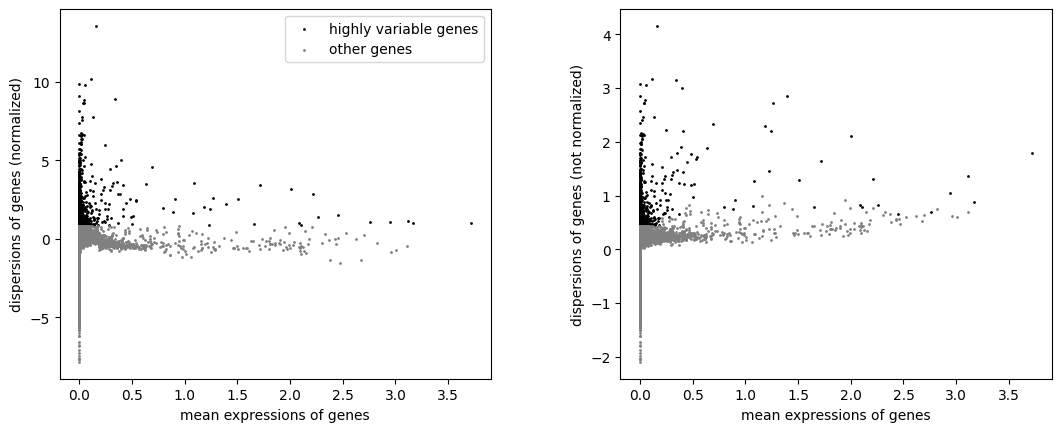

In [7]:
# HVG2000
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

In [8]:
adata.var.highly_variable.sum()

2000

In [9]:
# filtering HVG2000
adata = adata[:, adata.var.highly_variable]
adata.shape

(68579, 2000)

In [10]:
# regress out the unwanted sources of variation
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# Scale each gene to unit variance
# sc.pp.scale(adata, max_value=10)

## PCA

In [11]:
sc.tl.pca(adata, svd_solver="arpack")

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


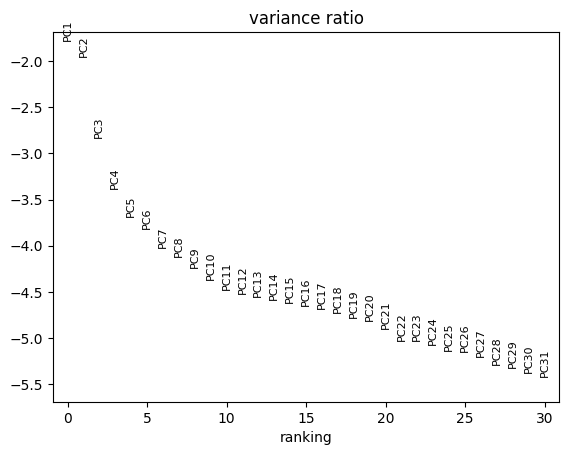

In [12]:
sc.pl.pca_variance_ratio(adata, log=True)

## UMAP

In [13]:
# neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
sc.tl.umap(adata)

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


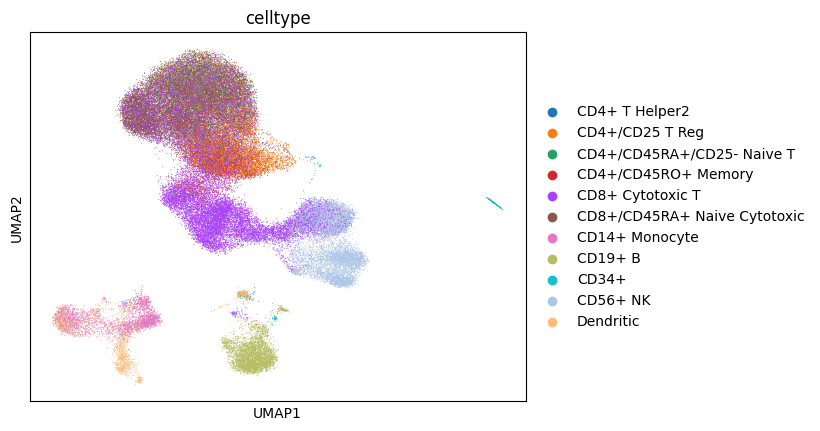

In [15]:
sc.pl.umap(adata, color='celltype')

## Leiden

In [16]:
sc.tl.leiden(adata, resolution=0.9)

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


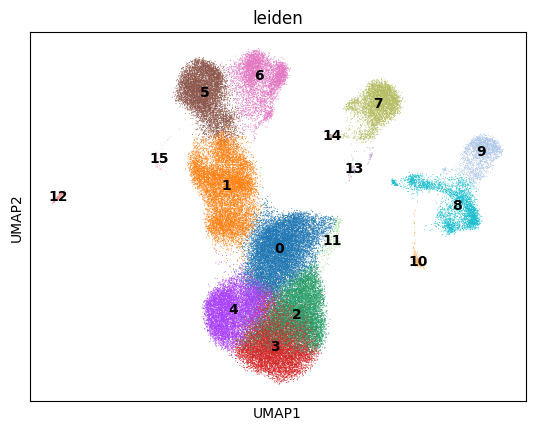

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


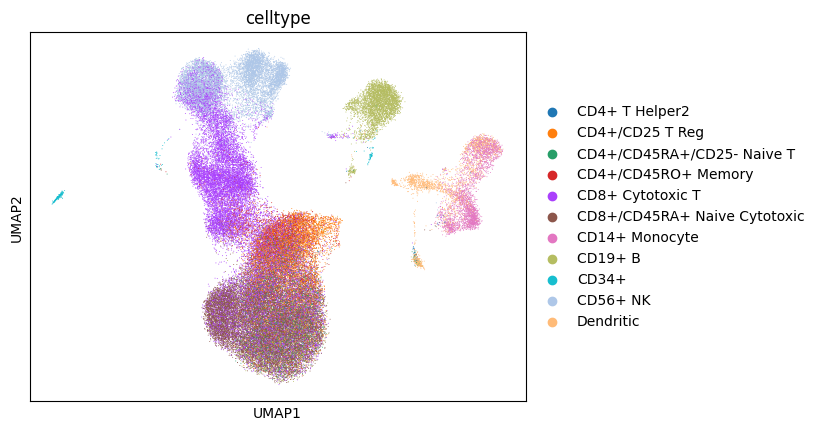

In [17]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color='leiden', legend_loc="on data")
sc.pl.umap(adata, color='celltype', legend_loc="right margin")

In [18]:
adata.obs['leiden'].unique()

['1', '4', '0', '7', '3', ..., '8', '9', '12', '13', '14']
Length: 16
Categories (16, object): ['0', '1', '2', '3', ..., '12', '13', '14', '15']

In [19]:
adata.obs.head()

,celltype,TSNE.1,TSNE.2,leiden
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370,1
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672,4
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846,0
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346,7
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970,3


In [28]:
cluster_names = []
for i in adata.obs['leiden'].tolist():
    cluster_names.append('Leiden_' + str(i))

adata.obs['leiden_cluster'] = cluster_names
adata.obs.head()


,celltype,TSNE.1,TSNE.2,leiden,leiden_cluster
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370,1,Leiden_1
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672,4,Leiden_4
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846,0,Leiden_0
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346,7,Leiden_7
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970,3,Leiden_3


In [29]:
adata.obs = adata.obs.drop('leiden', axis=1)
adata.obs.head()

,celltype,TSNE.1,TSNE.2,leiden_cluster
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370,Leiden_1
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672,Leiden_4
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846,Leiden_0
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346,Leiden_7
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970,Leiden_3


In [31]:
adata.obs['leiden_cluster'].value_counts()

leiden_cluster
Leiden_0     11601
Leiden_1      9488
Leiden_2      9408
Leiden_3      9046
Leiden_4      8167
Leiden_5      6801
Leiden_6      4578
Leiden_7      3815
Leiden_8      2893
Leiden_9      1767
Leiden_10      364
Leiden_11      216
Leiden_12      164
Leiden_13      145
Leiden_14       77
Leiden_15       49
Name: count, dtype: int64

In [30]:
# write subsetted HVG2000 and the leiden clustering to a new h5ad file
adata.write_h5ad('Zheng_PBMC_HVG2000_leiden_subset.h5ad')